# Dimensionless Analysis of SIPS 

In [130]:
using DifferentialEquations
using Plots

#Function to model the dimensionless absorption of gas into SIP material in linear coordinates via MOL approach.
#Discussed in blue workbook.
#Inputs: 
#α - dimensionless time-scaling parameter
#ϕ̄ - dimensionless Theile Modulus
#γ - dimensionless ratio of gas to active species concentration
#tf - final time
#m - The number of mesh points.
function DimensionlessLinearSIP(ϕ̄,γ,α,tf,m=50)
    
    #Pertinent Mesh Values
    h = 1/m         #Distance between neighbouring grid points
    
    #Define DE Problem
    function main(t,u,dudt)
        #Extract values from u
        c = u[1:m]
        w = u[m+1:2m]
        
        #Calculate change of concentration due to diffusion and reaction
        for i = 1:2m+1
            if i == 1
                dudt[i] = 1/α*(1/(ϕ̄^2*h^2)*(2c[2]-2c[1]) - c[1]*w[1])
            elseif 2 <= i <= m-1
                dudt[i] = 1/α*(1/(ϕ̄^2*h^2)*(c[i-1]-2c[i]+c[i+1]) - c[i]*w[i])
            elseif i == m
                dudt[i] = 1/α*(1/(ϕ̄^2*h^2)*(c[m-1]-2c[m]+1.0) - c[m]*w[m])
            elseif m+1 <= i <= 2m
                dudt[i] = -γ*c[i-m]*w[i-m]
            elseif i == 2m+1
                dudt[i] = ((3/2*1.0-2*c[m]+1/2*c[m-1])/h)*(1/(α*ϕ̄^2))
            end
        end
    end

    #Initial Conditions and timespan
    u0 = [zeros(m);ones(m);0.0]
    tspan = (0.0,tf)

    #Define and solve problem
    prob = ODEProblem(main,u0,tspan)
    sol = solve(prob, Rosenbrock23());
    return sol
end


#Function to model the dimensionless absorption of gas into Static Liquid in linear coordinates via MOL approach.
#Discussed in blue workbook.
#Inputs: 
#α - dimensionless time-scaling parameter
#ϕ̄ - dimensionless Theile Modulus
#γ - dimensionless ratio of gas to active species concentration
#tf - final time
#m - The number of mesh points.
function DimensionlessLinearLiq(ϕ,γ,tf,m=50)
    
    #Pertinent Mesh Values
    h = 1/m         #Distance between neighbouring grid points
    
    #Define DE Problem
    function main(t,u,dudt)
        #Extract values from u
        c = u[1:m]
        w = u[m+1]
        
        #Calculate change of concentration due to diffusion and reaction
        for i = 1:2m+1
            if i == 1
                dudt[i] = (1/(ϕ^2*h^2)*(2c[2]-2c[1]) - c[1]*w)
            elseif 2 <= i <= m-1
                dudt[i] = (1/(ϕ^2*h^2)*(c[i-1]-2c[i]+c[i+1]) - c[i]*w)
            elseif i == m
                dudt[i] = (1/(ϕ^2*h^2)*(c[m-1]-2c[m]+1.0) - c[m]*w)
            elseif i == m+1
                dudt[i] = -γ*w*1/m*(0.5*(c[1]+1)+sum([c[i] for i in 2:m]))
            elseif i == m+2
                dudt[i] = ((3/2*1.0-2*c[m]+1/2*c[m-1])/h)*(1/(ϕ^2))
            end
        end
    end

    #Initial Conditions and timespan
    u0 = [zeros(m);1.0;0.0]
    tspan = (0.0,tf)

    #Define and solve problem
    prob = ODEProblem(main,u0,tspan)
    sol = solve(prob, Rosenbrock23());
    return sol
end

DimensionlessLinearLiq (generic function with 2 methods)

## Analysing These Dimensionless Equations and Creating Plots

The two variables we are interested in are $\rho \equiv \mathcal{P}_s/\mathcal{P}_l$ and $\phi = L^2k_2/\mathcal{D}_l$. We will vary these and measure $t_{0.95}$ for each equation, and track how this ratio changes as they are varied.

In [604]:
ρ = ρrange[i]; ϕ = ϕrange[j]; α = 1.0; γ = 1e-3; ɛ = 0.5; ξ = 0.95; m = 100

#Calculate ϕ̄
ϕ̄ = ϕ*((1-ɛ)/(ɛ*ρ+(1-ɛ)))*((1-ɛ))^-2

#Solve Systems
tf = 10*max(ϕ,ϕ̄)^2/γ    #This is a reasonable estimate for the time our dimensionless system will take to solve, and perhaps could give clues as to a better dimensionless time
solLiq = DimensionlessLinearLiq(ϕ,γ,tf,m)
solSIP = DimensionlessLinearSIP(ϕ̄,γ,α,tf,m)

#Calculate point at which 95% of gas has been absorbed in liquid via bisection method
n_max_Liq = solLiq(tf)[m+2];  
t_min = 0.0; t_max = tf; ξ_temp = 0.0; tguess = 1.0
while abs(ξ_temp - ξ)/ξ > 0.001
    tguess = (t_min+t_max)/2.0
    ξ_temp = solLiq(tguess)[m+2]/n_max_Liq
    if ξ_temp < ξ
        t_min = tguess
    else
        t_max = tguess
    end
end
tξ_Liq = tguess

#Calculate point at which 95% of gas has been absorbed in SIP via bisection method
n_max_SIP = solSIP(tf)[2m+1]
t_min = 0.0; t_max = tf; ξ_temp = 0.0
while abs(ξ_temp - ξ)/ξ > 0.001
    tguess = (t_min+t_max)/2.0
    ξ_temp = solSIP(tguess)[2m+1]/n_max_SIP
    if ξ_temp < ξ
        t_min = tguess
    else
        t_max = tguess
    end
end
tξ_SIP = tguess

#Test
#println([solLiq(tξ_Liq)[m+2]/n_max_Liq,solSIP(tξ_SIP)[2m+1]/n_max_SIP])
#plot(solLiq(tξ_Liq)[1:m])
#plot!(solSIP(tξ_SIP)[1:m])

tξ_Liq/tξ_SIP

LoadError: Something went wrong. Integrator stepped past tstops but the algorithm was dtchangeable. Please report this error.


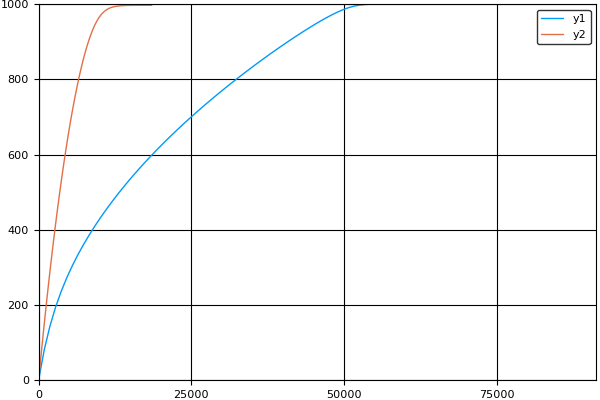

In [543]:
plot(linspace(0,tξ_SIP*2,100),[solSIP(i)[2m+1] for i in linspace(0,tξ_SIP*2,100)])
plot!(linspace(0,tξ_Liq*2,100),[solLiq(i)[m+2] for i in linspace(0,tξ_Liq*2,100)])


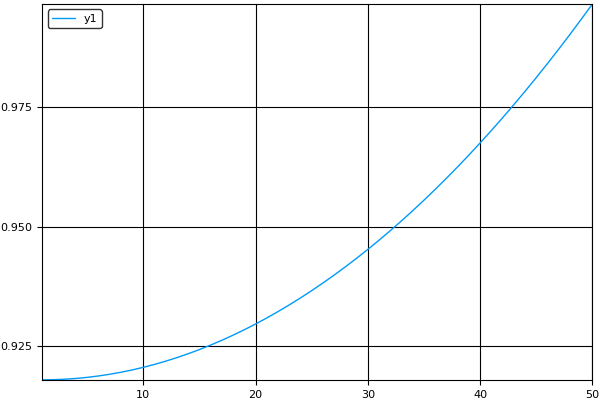

In [398]:
plot(solLiq(2000.0)[1:m])

In [369]:
tξ_SIP

2988.28125

In [565]:
ϕrange[j]

7.666666666666667

In [623]:
ρrange[i]

5

In [624]:
α = 1.0; γ = 1e-3; ɛ = 0.5; ξ = 0.95; m = 50
N = 100
ρrange = [1.0, 2.0, 5.0, 10.0,100.0]; ϕrange = logspace(-1,2,N);
storeratio = zeros(length(ρrange),length(ϕrange)); i = 0; j = 0
for ρ in ρrange
    j = 0; i = i + 1;
    for ϕ in ϕrange
        j = j + 1;
        #Calculate ϕ̄
        ϕ̄ = ϕ*((1-ɛ)/(ɛ*ρ+(1-ɛ)))*((1-ɛ))^-2

        #Solve Systems
        tf = 10*max(ϕ,ϕ̄)^2/γ    #This is a reasonable estimate for the time our dimensionless system will take to solve, and perhaps could give clues as to a better dimensionless time
        solLiq = try DimensionlessLinearLiq(ϕ,γ,tf,m) catch; (try DimensionlessLinearLiq(ϕ*1.001,γ,tf,m) catch; DimensionlessLinearLiq(0.999*ϕ,γ,tf,m) end) end
        solSIP = try DimensionlessLinearSIP(ϕ̄,γ,α,tf,m) catch; (try DimensionlessLinearSIP(ϕ̄*1.001,γ,α,tf,m) catch; DimensionlessLinearSIP(0.999*ϕ̄,γ,α,tf,m) end) end

        #Calculate point at which 95% of gas has been absorbed in liquid via bisection method
        n_max_Liq = solLiq(tf)[m+2];  
        t_min = 0.0; t_max = tf; ξ_temp = 0.0; tguess = 1.0
        while abs(ξ_temp - ξ)/ξ > 0.001
            tguess = (t_min+t_max)/2.0
            ξ_temp = solLiq(tguess)[m+2]/n_max_Liq
            if ξ_temp < ξ
                t_min = tguess
            else
                t_max = tguess
            end
        end
        tξ_Liq = tguess

        #Calculate point at which 95% of gas has been absorbed in SIP via bisection method
        n_max_SIP = solSIP(tf)[2m+1]
        t_min = 0.0; t_max = tf; ξ_temp = 0.0
        while abs(ξ_temp - ξ)/ξ > 0.001
            tguess = (t_min+t_max)/2.0
            ξ_temp = solSIP(tguess)[2m+1]/n_max_SIP
            if ξ_temp < ξ
                t_min = tguess
            else
                t_max = tguess
            end
        end
        tξ_SIP = tguess
        storeratio[i,j] = tξ_Liq/tξ_SIP
        println(j)
    end
    println(i)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
4


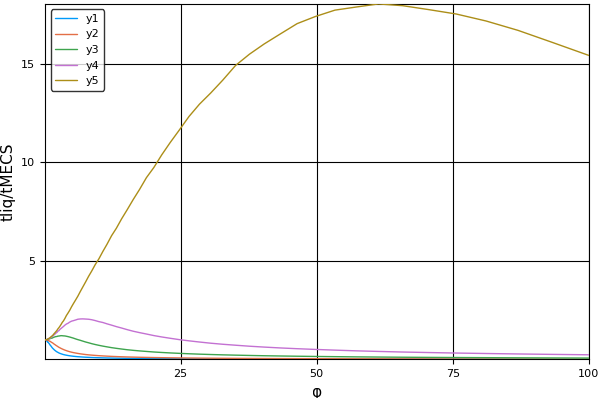

In [631]:
plot(ϕrange,[storeratio[1,j] for j in 1:N])
for i = [2,3,4,5]
    plot!(ϕrange,[storeratio[i,j] for j in 1:N])
end
xaxis!("ϕ")
yaxis!("tliq/tMECS")


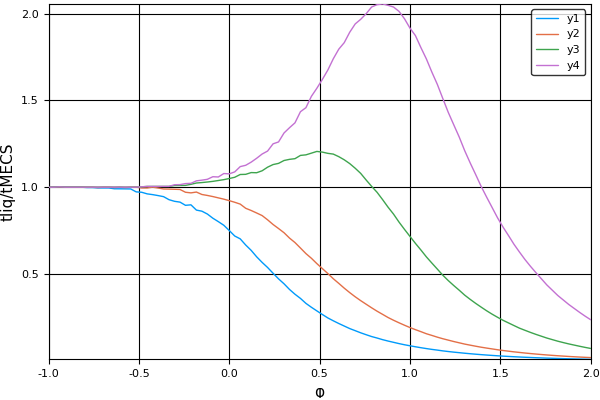

In [630]:
plot(log10(ϕrange),[storeratio[1,j] for j in 1:N])
for i = [2,3,4]
    plot!(log10(ϕrange),[storeratio[i,j] for j in 1:N])
end
xaxis!("ϕ")
yaxis!("tliq/tMECS")

In [637]:
α = 1.0; γ = 1e-3; ɛ = 0.5; ξ = 0.95; m = 50
N = 50
ϕrange = [1.0, 2.0, 5.0, 10.0,20.0]; ρrange = logspace(0,1,N);
storeratio = zeros(length(ρrange),length(ϕrange)); i = 0; j = 0
for ρ in ρrange
    j = 0; i = i + 1;
    for ϕ in ϕrange
        j = j + 1;
        #Calculate ϕ̄
        ϕ̄ = ϕ*((1-ɛ)/(ɛ*ρ+(1-ɛ)))*((1-ɛ))^-2

        #Solve Systems
        tf = 10*max(ϕ,ϕ̄)^2/γ    #This is a reasonable estimate for the time our dimensionless system will take to solve, and perhaps could give clues as to a better dimensionless time
        solLiq = try DimensionlessLinearLiq(ϕ,γ,tf,m) catch; (try DimensionlessLinearLiq(ϕ*1.001,γ,tf,m) catch; DimensionlessLinearLiq(0.999*ϕ,γ,tf,m) end) end
        solSIP = try DimensionlessLinearSIP(ϕ̄,γ,α,tf,m) catch; (try DimensionlessLinearSIP(ϕ̄*1.001,γ,α,tf,m) catch; DimensionlessLinearSIP(0.999*ϕ̄,γ,α,tf,m) end) end

        #Calculate point at which 95% of gas has been absorbed in liquid via bisection method
        n_max_Liq = solLiq(tf)[m+2];  
        t_min = 0.0; t_max = tf; ξ_temp = 0.0; tguess = 1.0
        while abs(ξ_temp - ξ)/ξ > 0.001
            tguess = (t_min+t_max)/2.0
            ξ_temp = solLiq(tguess)[m+2]/n_max_Liq
            if ξ_temp < ξ
                t_min = tguess
            else
                t_max = tguess
            end
        end
        tξ_Liq = tguess

        #Calculate point at which 95% of gas has been absorbed in SIP via bisection method
        n_max_SIP = solSIP(tf)[2m+1]
        t_min = 0.0; t_max = tf; ξ_temp = 0.0
        while abs(ξ_temp - ξ)/ξ > 0.001
            tguess = (t_min+t_max)/2.0
            ξ_temp = solSIP(tguess)[2m+1]/n_max_SIP
            if ξ_temp < ξ
                t_min = tguess
            else
                t_max = tguess
            end
        end
        tξ_SIP = tguess
        storeratio[i,j] = tξ_Liq/tξ_SIP
        println(j)
    end
    println(i)
end

1
2
3
4
5
1
1
2
3
4
5
2
1
2
3
4
5
3
1
2
3
4
5
4
1
2
3
4
5
5
1
2
3
4
5
6
1
2
3
4
5
7
1
2
3
4
5
8
1
2
3
4
5
9
1
2
3
4
5
10
1
2
3
4
5
11
1
2
3
4
5
12
1
2
3
4
5
13
1
2
3
4
5
14
1
2
3
4
5
15
1
2
3
4
5
16
1
2
3
4
5
17
1
2
3
4
5
18
1
2
3
4
5
19
1
2
3
4
5
20
1
2
3
4
5
21
1
2
3
4
5
22
1
2
3
4
5
23
1
2
3
4
5
24
1
2
3
4
5
25
1
2
3
4
5
26
1
2
3
4
5
27
1
2
3
4
5
28
1
2
3
4
5
29
1
2
3
4
5
30
1
2
3
4
5
31
1
2
3
4
5
32
1
2
3
4
5
33
1
2
3
4
5
34
1
2
3
4
5
35
1
2
3
4
5
36
1
2
3
4
5
37
1
2
3
4
5
38
1
2
3
4
5
39
1
2
3
4
5
40
1
2
3
4
5
41
1
2
3
4
5
42
1
2
3
4
5
43
1
2
3
4
5
44
1
2
3
4
5
45
1
2
3
4
5
46
1
2
3
4
5
47
1
2
3
4
5
48
1
2
3
4
5
49
1
2
3
4
5
50



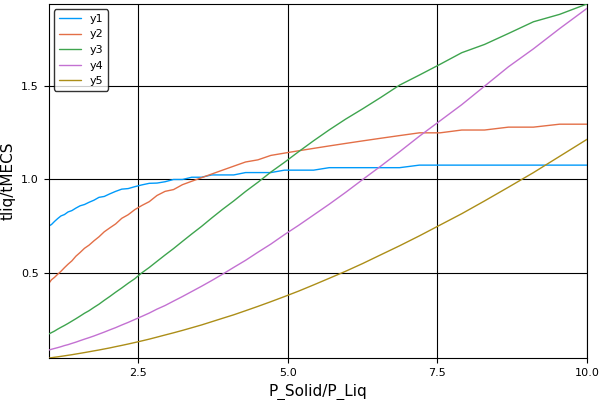

In [638]:
plot(ρrange,[storeratio[i,1] for i in 1:N])
for j = [2,3,4,5]
    plot!(ρrange,[storeratio[i,j] for i in 1:N])
end
xaxis!("P_Solid/P_Liq")
yaxis!("tliq/tMECS")


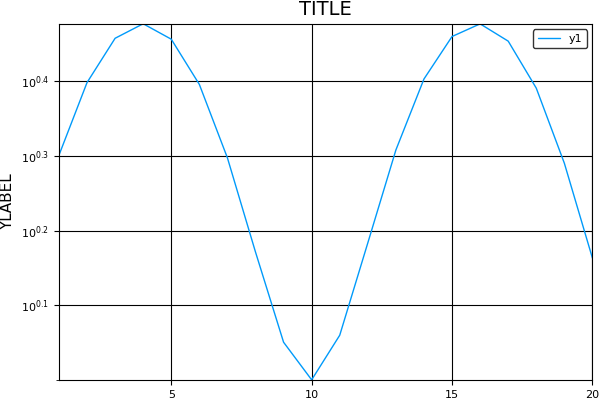

In [496]:
x = linspace(0,10,20)
y = sin(x)+2
plot(y)
title!("TITLE")
yaxis!("YLABEL",:log10)

In [610]:
aa = try DimensionlessLinearLiq(ϕ,γ,tf,m) catch; DimensionlessLinearLiq(ϕ,γ,tf,m+1) end

DiffEqBase.ODESolution{Float64,2,Array{Array{Float64,1},1},Void,Void,Array{Float64,1},Array{Array{Array{Float64,1},1},1},DiffEqBase.ODEProblem{Array{Float64,1},Float64,true,#main#17{Float64,Float64,Int64,Float64},Void,UniformScaling{Int64}},OrdinaryDiffEq.Rosenbrock23{0,true,DiffEqBase.LinSolveFactorize{Base.LinAlg.#lufact!}},OrdinaryDiffEq.InterpolationData{#main#17{Float64,Float64,Int64,Float64},Array{Array{Float64,1},1},Array{Float64,1},Array{Array{Array{Float64,1},1},1},OrdinaryDiffEq.Rosenbrock23Cache{Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{ForwardDiff.Dual{10,Float64},1},Array{Float64,1},Array{Float64,2},OrdinaryDiffEq.Rosenbrock23ConstantCache{Float64,Base.#identity,Base.#identity},OrdinaryDiffEq.TimeGradientWrapper{OrdinaryDiffEq.VectorF{#main#17{Float64,Float64,Int64,Float64},Tuple{Int64}},Array{Float64,1},Array{ForwardDiff.Dual{10,Float64},1}},OrdinaryDiffEq.UJacobianWrapper{OrdinaryDiffEq.VectorFReturn{#main#17{Float64,Float64,Int64,Float64},Tuple{Int64}},Fl

In [621]:
DimensionlessLinearLiq(ϕ,γ,tf,m)

LoadError: Something went wrong. Integrator stepped past tstops but the algorithm was dtchangeable. Please report this error.

## Testing Dimensionless Equations

### alpha makes no difference

In [134]:
ϕ̄ = 17.0; γ = 0.001; α = 1; tf = 1e6; m = 50;
@time sol1 = DimensionlessLinearSIP(ϕ̄,γ,α,tf,m);
sol2 = DimensionlessLinearSIP(ϕ̄,γ,2α,tf,m);
sol3 = DimensionlessLinearSIP(ϕ̄,γ,5α,tf,m);
sol4 = DimensionlessLinearSIP(ϕ̄,γ,0.5α,tf,m);
sol5 = DimensionlessLinearSIP(ϕ̄,γ,0.2α,tf,m);

  0.385264 seconds (274.85 k allocations: 37.539 MB, 1.27% gc time)



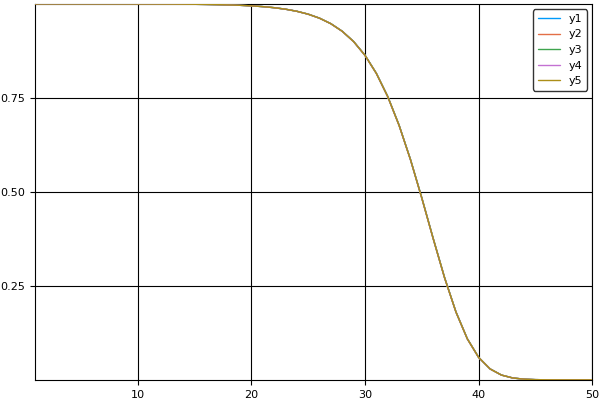

In [135]:
 plot(sol1(17000.0)[m+1:2m])
plot!(sol2(17000.0)[m+1:2m])
plot!(sol3(17000.0)[m+1:2m])
plot!(sol4(17000.0)[m+1:2m])
plot!(sol5(17000.0)[m+1:2m])


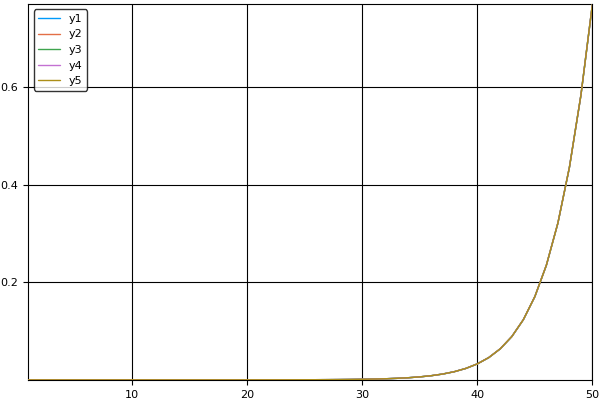

In [136]:
plot(sol1(1000.0)[1:m])
plot!(sol2(1000.0)[1:m])
plot!(sol3(1000.0)[1:m])
plot!(sol4(1000.0)[1:m])
plot!(sol5(1000.0)[1:m])

In [292]:
ϕ = .0010; ϕ̄ = ϕ/3; α = 1.0; γ = 0.001; α = 1; tf = 1e9; m = 50;
@time lsol1 = DimensionlessLinearLiq(ϕ,γ,tf,m);
@time sol1  = DimensionlessLinearSIP(ϕ̄,γ,α,tf,m);

  0.121696 seconds (68.36 k allocations: 8.870 MB, 3.39% gc time)
  0.213123 seconds (140.23 k allocations: 19.236 MB, 1.44% gc time)



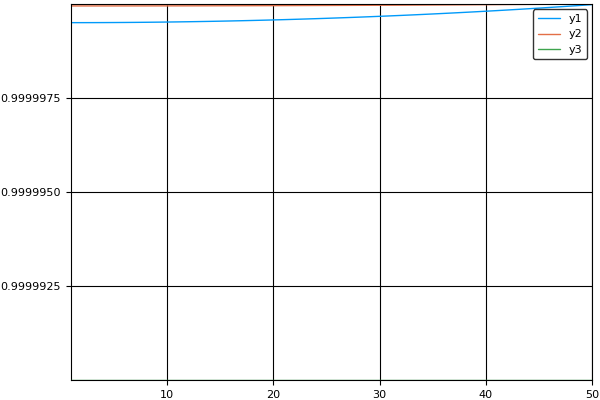

In [293]:
plot(lsol1(10*max(ϕ̄,ϕ)^2/(γ))[1:m])
plot!(sol1(10*max(ϕ̄,ϕ)^2/(γ))[1:m])
plot!(sol1(10*max(ϕ̄,ϕ)^2/(γ))[m+1:2m])

In [278]:
ϕ̄^2/(γ)

11111.111111111113

In [242]:
γ

0.001